# 🗳️ Comitê de Modelos (Ensemble Learning)
> **Fase Final - Time 7**

Vamos carregar todos os modelos treinados, comparar suas performances lado a lado e selecionar os **Top 3** para formar um **Voting Classifier** (Classificador por Votação).

**Estratégia:**
1.  **Carga:** Importar todos os `.pkl` da pasta `models/`.
2.  **Peneira:** Avaliar todos no dataset de Teste.
3.  **Seleção:** Escolher os 3 melhores em Recall.
4.  **Fusão:** Criar um modelo único que toma decisão baseada na média das probabilidades dos 3 campeões (*Soft Voting*).

## 1. Configuração de Ambiente

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, ConfusionMatrixDisplay, classification_report, confusion_matrix

# Configuração visual
sns.set_theme(style="whitegrid")

In [3]:
# Carregando dados de teste para avaliar os candidatos
# Nota: Precisamos do X_train/y_train para "oficializar" o comitê no final
try:
    X_train = joblib.load('../data/processed/X_train.pkl')
    y_train = joblib.load('../data/processed/y_train.pkl')
    X_test = joblib.load('../data/processed/X_test.pkl')
    y_test = joblib.load('../data/processed/y_test.pkl')
    
    print(f"Dados carregados!")
except FileNotFoundError:
    print("Rode o pré-processamento primeiro.")

Dados carregados!


In [6]:
# Listando e carregando os modelos da pasta models/
folder = '../models/'
model_files = [f for f in os.listdir(folder) if f.endswith('.pkl') and 'modelo_' in f]

ignor = 'modelo_FINAL_Comite.pkl'  # Ignorar o comitê final, se existir
modelos_carregados = {}

print("Carregando modelos treinados:")
for file in model_files:
    path = os.path.join(folder, file)
    # Extrai o nome limpo (Ex: modelo_SVM.pkl -> SVM)
    name = file.replace('modelo_', '').replace('.pkl', '').replace('_Otimizado', '')
    if file != ignor:
        try:
            model = joblib.load(path)
            modelos_carregados[name] = model
            print(f"- {name} carregado com sucesso.")
        except Exception as e:
            print(f"Erro ao carregar {file}: {e}")
            print(f"Falha ao carregar {file}")

print(f"\nTotal de candidatos: {len(modelos_carregados)}")

Carregando modelos treinados:
- ArvoreDecisao carregado com sucesso.
- KNN carregado com sucesso.
- SVM carregado com sucesso.
- RandomForest carregado com sucesso.
- RedesNeurais carregado com sucesso.
- RegressaoLogistica carregado com sucesso.

Total de candidatos: 6


## 2. Formação do Comitê (Ensemble)

Selecionaremos os **Top 3 modelos** do ranking.
Utilizaremos a estratégia de **Soft Voting**:
* O comitê não olha apenas o voto final (Sim/Não).
* Ele olha a **certeza** de cada modelo (Probabilidade).
* Exemplo: Se o SVM diz 90% de chance de doença e a Árvore diz 40%, a média é 65% -> **Doente**.

/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


🏆 RANKING OFICIAL:


/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Modelo,Recall,Acurácia,Precisão,Limiar Usado
4,RedesNeurais,0.871560,0.746835,0.673759,0.20
1,KNN,0.862385,0.772152,0.706767,0.30
3,RandomForest,0.853211,0.755274,0.688889,0.41
2,SVM,0.853211,0.742616,0.673913,0.35
5,RegressaoLogistica,0.779817,0.814346,0.809524,0.50
0,ArvoreDecisao,0.715596,0.772152,0.772277,0.50


/tmp/ipykernel_1424915/8186251.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x='Recall', y='Modelo', palette='magma')


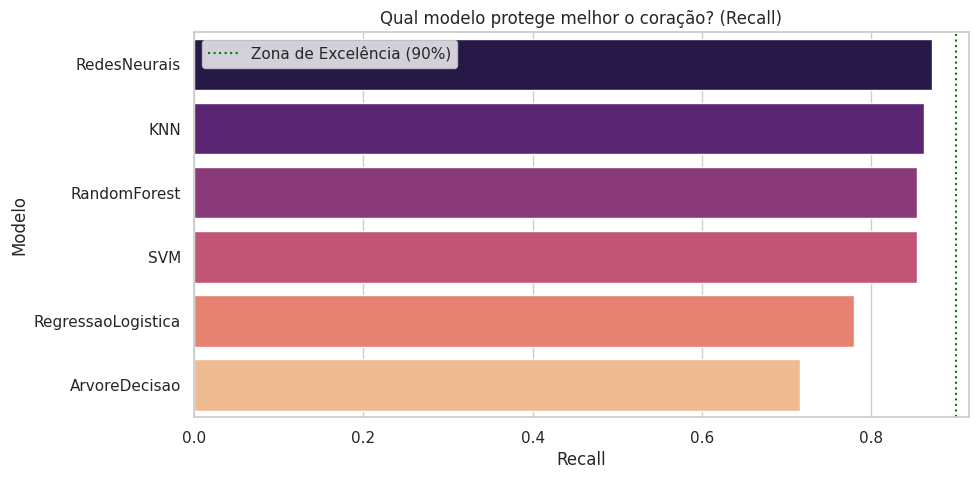

In [11]:
# Avaliando cada modelo individualmente

# Definindo limiares personalizados
limiares_personalizados = {
    'SVM': 0.35,              
    'RandomForest': 0.41,     
    'RedesNeurais': 0.20,     
    'RegressaoLogistica': 0.5,
    'KNN': 0.30,               
    'ArvoreDecisao': 0.5
}

# Vamos rodar todos no X_test e ver quem manda bem no Recall
resultados = []

for name, model in modelos_carregados.items():
    
    # 1. Definindo o limiar (Pega do dicionário ou usa 0.5 se não achar)
    # O nome do arquivo pode vir como 'SVM_Otimizado', então buscamos substring
    limiar = 0.5
    for key, val in limiares_personalizados.items():
        if key in name: # Se "SVM" estiver no nome "modelo_SVM_Otimizado"
            limiar = val
            break
            
    # 2. Fazendo a previsão com o limiar correto
    try:
        if hasattr(model, "predict_proba"):
            # Pega probabilidade da classe 1 (Doente)
            probas_cv = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
            y_pred_cv = (probas_cv >= limiar).astype(int)
            metodo = "Probabilidade (Soft Voting)"
        else:
            # Se o modelo não suportar probabilidade, usa o padrão
            y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5)
            metodo = "Padrão (Hard Voting)"
    except Exception as e:
        print(f"⚠️ Erro ao prever com {name}: {e}")
        continue

    # 3. Calculando Métricas
    rec = recall_score(y_train, y_pred_cv)
    acc = accuracy_score(y_train, y_pred_cv)
    prec = precision_score(y_train, y_pred_cv)
    
    resultados.append({
        'Modelo': name,
        'Recall': rec,
        'Acurácia': acc,
        'Precisão': prec,
        'Limiar Usado': limiar,
        'Objeto': model
    })

# 4. Exibindo o Ranking
df_results = pd.DataFrame(resultados).sort_values(by='Recall', ascending=False)

print("🏆 RANKING OFICIAL:")
display(df_results[['Modelo', 'Recall', 'Acurácia', 'Precisão', 'Limiar Usado']])

# Gráfico
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x='Recall', y='Modelo', palette='magma')
plt.axvline(0.90, color='green', linestyle=':', label='Zona de Excelência (90%)')
plt.title("Qual modelo protege melhor o coração? (Recall)")
plt.legend()
plt.show()

In [12]:
# 1. Pegando os 3 melhores
top3_df = df_results.head(3)
print(f"Os escolhidos para o comitê: {top3_df['Modelo'].tolist()}")

# 2. Preparando a lista de tuplas para o Scikit-Learn
estimators_list = []
for index, row in top3_df.iterrows():
    estimators_list.append((row['Modelo'], row['Objeto']))

# 3. Criando o Comitê (VotingClassifier)
# voting='soft' usa a média das probabilidades (Requer que os modelos tenham predict_proba)
comite = VotingClassifier(estimators=estimators_list, voting='soft')

# 4. Treinando o Comitê
# Nota: Embora os modelos já estejam treinados, o VotingClassifier precisa
# ser "ajustado" para conhecer as classes. Como nossos modelos já têm os melhores
# hiperparâmetros, o fit aqui é rápido e seguro.
comite.fit(X_train, y_train)
print("Comitê pronto!")

Os escolhidos para o comitê: ['RedesNeurais', 'KNN', 'RandomForest']
Comitê pronto!


/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----------------------------------------
🤖 PERFORMANCE DO COMITÊ (Limiar 0.3):
   Recall Final:   89.29%
   Acurácia Final: 81.67%
----------------------------------------


<Figure size 600x500 with 0 Axes>

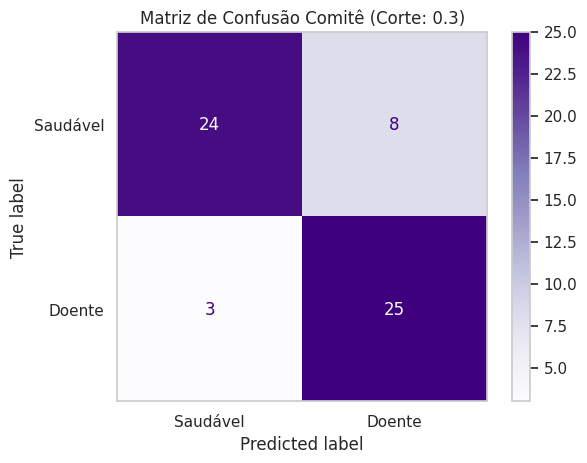

SUCESSO: O Comitê igualou ou superou o melhor especialista!


In [15]:
# 1. Pegando a probabilidade média do comitê (0 a 1)
# O soft voting faz a média das probabilidades dos 3 modelos escolhidos
y_proba_comite = comite.predict_proba(X_test)[:, 1]

# 3. Aplicando o Vencedor
limiar = 0.30
y_pred_comite = (y_proba_comite >= limiar).astype(int)

# AVALIAÇÃO FINAL
recall_comite = recall_score(y_test, y_pred_comite)
acc_comite = accuracy_score(y_test, y_pred_comite)

print("-" * 40)
print(f"🤖 PERFORMANCE DO COMITÊ (Limiar {limiar}):")
print(f"   Recall Final:   {recall_comite:.2%}")
print(f"   Acurácia Final: {acc_comite:.2%}")
print("-" * 40)

# Matriz de Confusão
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_comite, cmap='Purples', display_labels=['Saudável', 'Doente'])
plt.title(f'Matriz de Confusão Comitê (Corte: {limiar})')
plt.grid(False)
plt.show()

# Comparação com o Melhor Modelo Individual
# Pegamos o melhor recall da tabela anterior para comparar
melhor_individual = df_results.iloc[0]['Recall']

if recall_comite >= melhor_individual:
    print("SUCESSO: O Comitê igualou ou superou o melhor especialista!")
elif (melhor_individual - recall_comite) < 0.05:
    print(f"EMPATE TÉCNICO: O Comitê está muito estável (Recall: {recall_comite:.2%}).")
else:
    print(f"O Comitê ficou abaixo do campeão ({melhor_individual:.2%}).")
    print("Dica: Talvez o 'pior' dos 3 modelos esteja puxando a média para baixo. Tente um Comitê só com Top 2.")

In [18]:
# Comparação com o Melhor Modelo Individual no Teste
# Pegamos o objeto do melhor modelo e testamos ele no X_test agora
melhor_modelo_nome = df_results.iloc[0]['Modelo']
melhor_modelo_obj = df_results.iloc[0]['Objeto']

# Previsão do melhor individual no teste
if hasattr(melhor_modelo_obj, "predict_proba"):
    proba_ind = melhor_modelo_obj.predict_proba(X_test)[:, 1]
    y_pred_ind = (proba_ind >= df_results.iloc[0]['Limiar Usado']).astype(int)
else:
    y_pred_ind = melhor_modelo_obj.predict(X_test)

recall_individual_test = recall_score(y_test, y_pred_ind)

print(f"\n🥊 DUELO FINAL:")
print(f"Campeão Individual ({melhor_modelo_nome}): {recall_individual_test:.2%}")
print(f"Comitê (Ensemble):                     {recall_comite:.2%}")

if recall_comite > recall_individual_test:
    print(">> O Comitê SUPEROU o melhor especialista!")
elif recall_comite == recall_individual_test:
    print(">> EMPATE: O Comitê manteve a performance máxima.")
else:
    print(">> O especialista individual venceu no teste.")


🥊 DUELO FINAL:
Campeão Individual (RedesNeurais): 92.86%
Comitê (Ensemble):                     89.29%
>> O especialista individual venceu no teste.


## 3. Exportação Final

In [19]:
# Salvando o modelo definitivo do projeto
os.makedirs('../models', exist_ok=True)
joblib.dump(comite, '../models/modelo_VotingClassifier.pkl')

print("💾 Modelo do Comitê salvo como 'modelo_VotingClassifier.pkl'")

💾 Modelo do Comitê salvo como 'modelo_VotingClassifier.pkl'
